In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dense,Flatten
import warnings
warnings.filterswarnings=('ignore')

In [2]:
df=tf.keras.preprocessing.image_dataset_from_directory(r"C:\Users\Nalamati Yasaswini\Documents\DL Project\D2\DLL2",seed=123,
    shuffle=True,
    image_size=(256,256),
    batch_size=32
)

Found 4452 files belonging to 9 classes.


In [3]:
classes=df.class_names
classes

['Brown_spot-20230613T073335Z-001',
 'Healthy-20230613T073432Z-001',
 'Hispa-20230613T073455Z-001',
 'Narrow_brown_spot-20230613T073510Z-001',
 'Shath Blight-20230613T073514Z-001',
 'Tungro-20230613T073535Z-001',
 'bacterial_leaf_blight-20230613T073334Z-001',
 'leaf_blast-20230613T073503Z-001',
 'leaf_scald-20230613T073507Z-001']

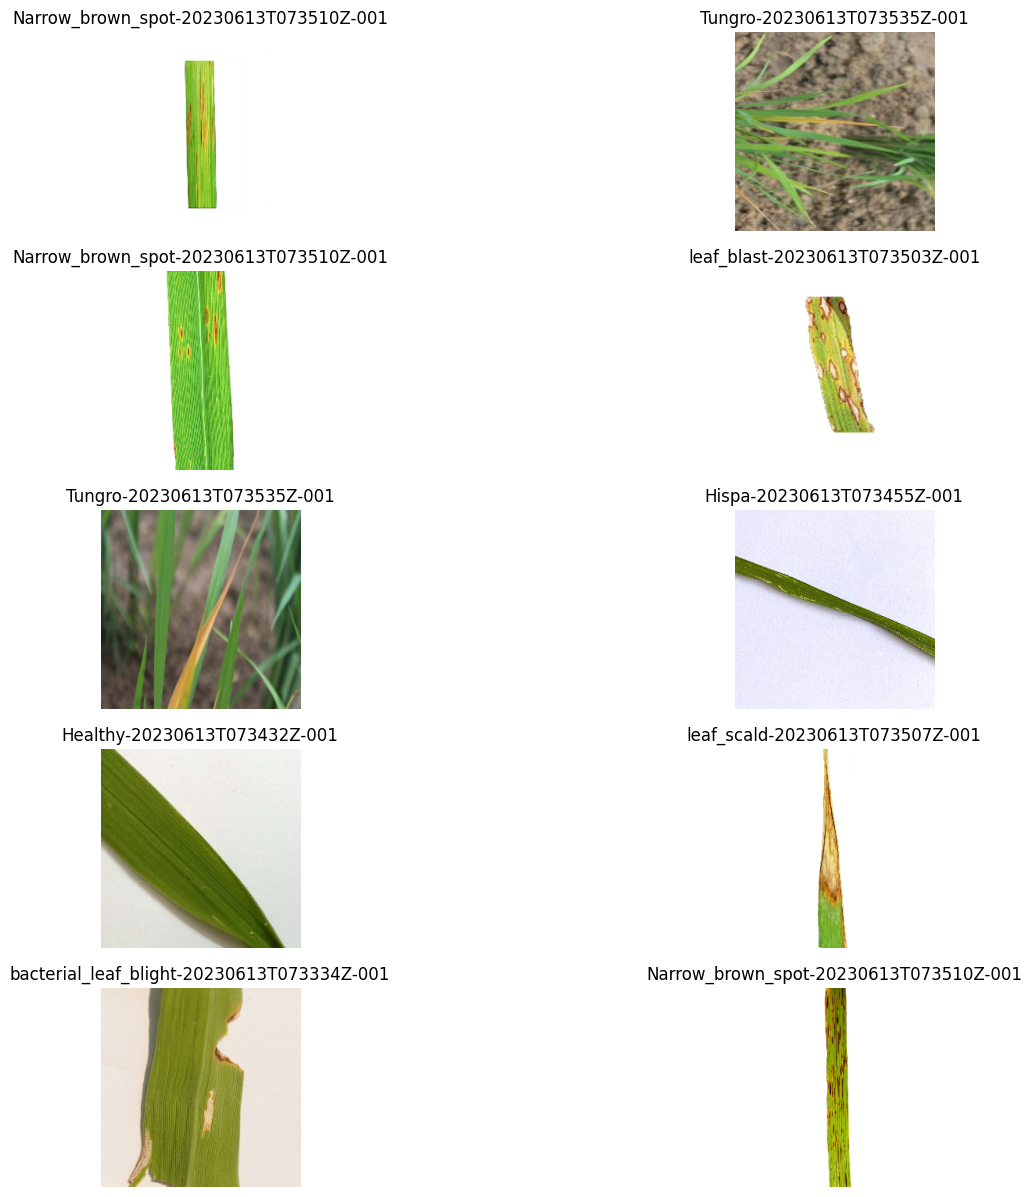

In [4]:
plt.figure(figsize=(15, 15))
for image_batch, labels_batch in df.take(7):
    for i in range(10):
        ax = plt.subplot(5,2, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(classes[labels_batch[i]])
        plt.axis("off")

In [5]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [17]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(df)

In [18]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [19]:
from tensorflow.keras import layers 
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(256,256),
  layers.experimental.preprocessing.Rescaling(1./255),
  
])

In [20]:
# rotating and flipping the images

data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
    ])


In [21]:
#inserting the augmented data
train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y)).prefetch(buffer_size=tf.data.AUTOTUNE)

In [22]:
from tensorflow.keras import models
input_shape = (32, 256, 256, 3)
n_classes = 9

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),
    
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),
    
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [23]:
#checking the summary
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (32, 127, 127, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                 

In [24]:
#compiling the model
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [25]:
history = model.fit(
    train_ds,
    batch_size=32,
    validation_data=val_ds,
    verbose=1,
    epochs=60,
)

Epoch 1/60
112/112 [==============================] - 240s 2s/step - loss: 1.5073 - accuracy: 0.4305 - val_loss: 1.3771 - val_accuracy: 0.5179
Epoch 2/60
112/112 [==============================] - 193s 2s/step - loss: 1.1729 - accuracy: 0.5585 - val_loss: 1.1770 - val_accuracy: 0.6071
Epoch 3/60
112/112 [==============================] - 194s 2s/step - loss: 1.0600 - accuracy: 0.6100 - val_loss: 0.9499 - val_accuracy: 0.6763
Epoch 4/60
112/112 [==============================] - 188s 2s/step - loss: 0.9046 - accuracy: 0.6651 - val_loss: 1.2834 - val_accuracy: 0.5201
Epoch 5/60
112/112 [==============================] - 185s 2s/step - loss: 0.7696 - accuracy: 0.7202 - val_loss: 0.7870 - val_accuracy: 0.7254
Epoch 6/60
112/112 [==============================] - 185s 2s/step - loss: 0.6828 - accuracy: 0.7567 - val_loss: 0.8929 - val_accuracy: 0.6808
Epoch 7/60
112/112 [==============================] - 184s 2s/step - loss: 0.6526 - accuracy: 0.7694 - val_loss: 0.9945 - val_accuracy: 0.6228

In [26]:
train_scores = model.evaluate(train_ds)
test_scores = model.evaluate(test_ds)

14/14 [==============================] - 26s 277ms/step - loss: 1.6396 - accuracy: 0.6406


first image to predict
actual label: Narrow_brown_spot-20230613T073510Z-001
1/1 [==============================] - 1s 584ms/step
predicted label: Tungro-20230613T073535Z-001
first image to predict
actual label: leaf_blast-20230613T073503Z-001
1/1 [==============================] - 0s 272ms/step
predicted label: Hispa-20230613T073455Z-001


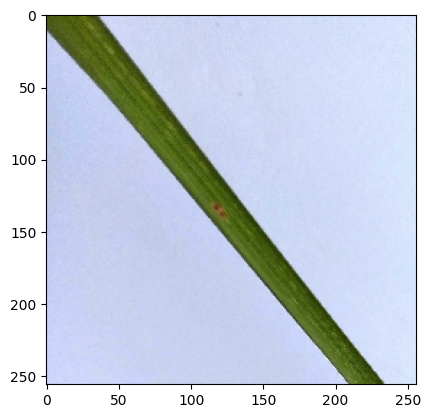

In [27]:
import numpy as np
for images_batch, labels_batch in test_ds.take(2):
    
    first_image = images_batch[19].numpy().astype('uint8')
    first_label = labels_batch[19].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",classes[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",classes[np.argmax(batch_prediction[0])])

In [28]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = classes[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 26ms/step


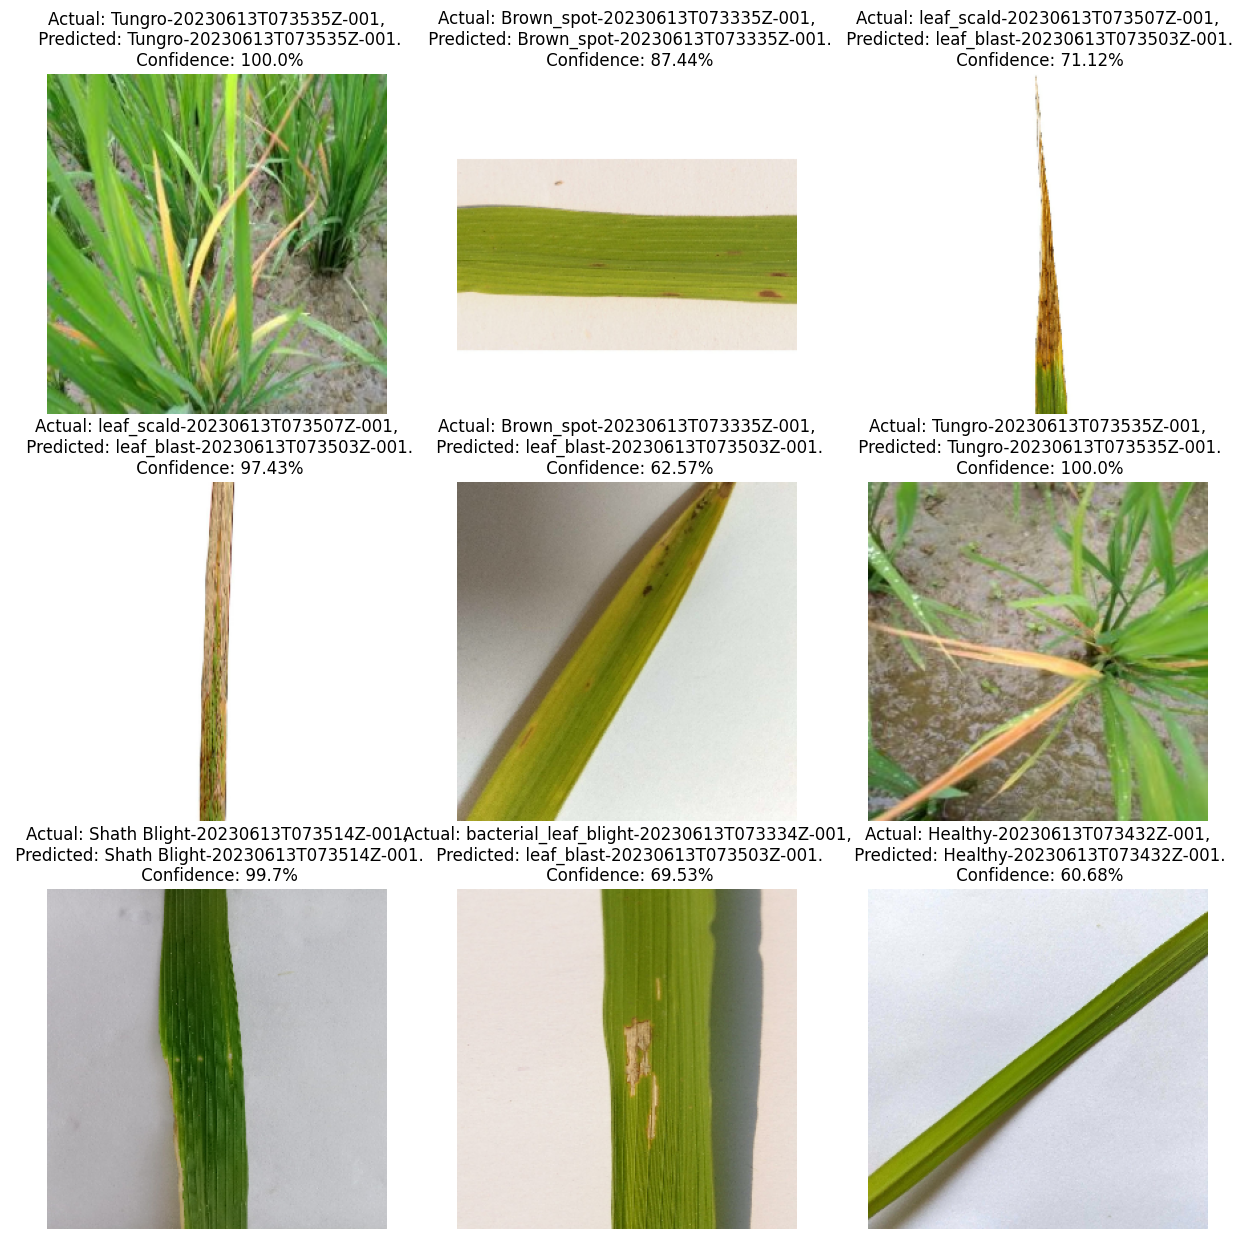

In [29]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = classes[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")